In [1]:
import numpy as np
import json
from gen_landscape import *
import seaborn as sns

In [18]:
#there is only one place where the code is loci specific,
#its in where we look up the fitness values
#other than that the function is entirely independent of any speciic loci value.
class Population():
    def __init__(self, population_size, loci, gene_mean, gene_sd, proportion_asexual,
                 survival_rate, mutation_std, landscape):
        self.population_size = population_size
        self.loci = loci
        self.organism_capacity = round(survival_rate * population_size)
        self.total_pop_mat = np.around(np.random.normal(gene_mean, gene_sd, (loci, self.population_size)), decimals=0)
        self.separator = round(self.population_size * proportion_asexual)  # To indicate where the asex ends and sex begins
        self.mutation_std = mutation_std #we assume mutation mean is 0
        self.landscape = landscape
        self.repl_ratio = 1/survival_rate
    
    def asex_pop_matrix(self):
        asex_matrix = self.total_pop_mat[:, :self.separator]
        return asex_matrix

    def sex_pop_matrix(self):
        sex_matrix = self.total_pop_mat[:, self.separator:]
        return sex_matrix
            
    def population_sizes(self, total=False, asex=False, sex=False):
        if total == True:
            return self.total_pop_mat.shape[1]
        if asex == True:
            return self.asex_pop_matrix().shape[1]
        if sex == True:
            return self.sex_pop_matrix().shape[1]
        
    def mutation_stage(self):
        shape = self.total_pop_mat.shape
        mutation_matrix = np.around(np.random.normal(0, self.mutation_std, shape), decimals=0)
        self.total_pop_mat = self.total_pop_mat + mutation_matrix
    
    def get_fitness(self, organisms):
        #organisms matrix: loci * population size
        seperate_loci = [organisms[locus, :] for locus in range(self.loci)]
        print('sep loci', seperate_loci)
        #THIS IS DIMENSION DEPENDENT!
        if self.loci == 2:
            indep_fitness = np.array(self.landscape.get_points(seperate_loci[0], seperate_loci[1]))
            #We normalize, to allow for proportional survival thats independent of how high in the
            #clouds you are - higher means selection weaker
            base_fitness = np.min(indep_fitness) - 1 #the minus one is to make the future base 1, not 0
            dep_fitness = np.subtract(indep_fitness, base_fitness)
            return(dep_fitness)
        else:
            print('Loci dimension not considered')   
    
    def survival_stage(self):
        #OKAY, fragile section, simulation especially vulnerable to definitions here
        #for this to work, the fitness landscape might need to be changed.
        curr_population_index = range(self.population_sizes(total=True))
        
        total_fitness_array = self.get_fitness(self.total_pop_mat)
        total_fitness = np.sum(total_fitness_array)
        prop_fitness = np.divide(total_fitness_array, total_fitness)
        
        survivor_list = np.random.choice(curr_population_index, self.organism_capacity, replace=False, p=prop_fitness)
        survivor_list = np.sort(survivor_list)
        
        self.total_pop_mat = (self.total_pop_mat)[:, survivor_list]
        self.separator = np.size(np.where(survivor_list < self.separator))
    
    def replication_stage(self):
        
        def pure_replication(organisms):
            num_organisms = organisms.shape[1]
            population_index = np.arange(0, num_organisms)
            next_gen_size = round(num_organisms* self.repl_ratio)
            
            next_gen_chosen = np.random.choice(population_index, size=next_gen_size, replace=True)
            next_gen = organisms[:, next_gen_chosen]
            
            return next_gen       
        
        #both populations go through pure replication first
        
        def recombination(organisms):
            for i in range(self.loci):
                np.random.shuffle(organisms[i])
            return organisms
        
        #both population have replication stage
        #we seperate to help track seperator through process
        new_asex_pop = pure_replication(self.asex_pop_matrix())
        pre_new_sex_pop = pure_replication(self.sex_pop_matrix())

        #then the sexuals also go through recombination
        new_sex_pop = recombination(pre_new_sex_pop)
        
        self.total_pop_mat = np.concatenate([new_asex_pop, new_sex_pop], axis=1)
        self.separator = new_asex_pop.shape[1]
        
    def view_population(self):
        if self.loci != 2:
            print('wrong loci count')
            return 0
        
        curr_max, curr_min = np.amax(self.total_pop_mat), np.amin(self.total_pop_mat)
        f, ax = plt.subplots(figsize=(8, 8))
        ax.set_aspect("equal")
        
        asex_0, asex_1 = self.asex_pop_matrix()[0,:], self.asex_pop_matrix()[1,:]
        ax = sns.kdeplot(asex_0, asex_1, n_levels=30, cmap="Blues")
        
        sex_0, sex_1 = self.sex_pop_matrix()[0,:], self.sex_pop_matrix()[1,:]
        ax = sns.kdeplot(sex_0, sex_1, n_levels=30, cmap="Reds") 
        
        
        
        

In [19]:
class Camera():
    def __init__(self):
        self.shot_num = 0
        self.camera_roll = {}
        #these are useful in the viewing stage
        self.frame_min = 0
        self.frame_max = 0
        
    def update_frame_size(self, population):
        curr_max, curr_min = np.amax(population.total_pop_mat), np.amin(population.total_pop_mat)
        if self.frame_max < curr_max:
            self.frame_max = curr_max
        if self.frame_min > curr_min:
            self.frame_min = curr_min
        
    def take_shot(self, population):
        self.update_frame_size(population)
            
        shot = (population.sex_pop_matrix(), population.asex_pop_matrix())
        self.camera_roll[self.shot_num] = shot
        self.shot_num +=1
        
    def view(self):
        #DESIGNED FOR ONLY 2 LOCI
        x, y = (self.camera_roll[0])[0][0,:], (self.camera_roll[0])[0][1,:]
        g = sns.JointGrid(x, y, size=8)
        frame_size = (self.frame_min, self.frame_max)
        
        def prep_axes(g, xlim, ylim):
            g.ax_joint.clear()
            g.ax_joint.set_xlim(xlim)
            g.ax_joint.set_ylim(ylim)
            g.ax_marg_x.clear()
            g.ax_marg_x.set_xlim(xlim)
            g.ax_marg_y.clear()
            g.ax_marg_y.set_ylim(ylim)
            plt.setp(g.ax_marg_x.get_xticklabels(), visible=False)
            plt.setp(g.ax_marg_y.get_yticklabels(), visible=False)
            plt.setp(g.ax_marg_x.yaxis.get_majorticklines(), visible=False)
            plt.setp(g.ax_marg_x.yaxis.get_minorticklines(), visible=False)
            plt.setp(g.ax_marg_y.xaxis.get_majorticklines(), visible=False)
            plt.setp(g.ax_marg_y.xaxis.get_minorticklines(), visible=False)
            plt.setp(g.ax_marg_x.get_yticklabels(), visible=False)
            plt.setp(g.ax_marg_y.get_xticklabels(), visible=False)
            
        def animate(i):
            prep_axes(g, frame_size, frame_size)
            (sex_data, asex_data) = self.camera_roll[i]
            g.x, g.y = sex_data[0, :],sex_data[1, :]
            g.plot_joint(sns.kdeplot, cmap="Reds")
            g.plot_marginals(sns.kdeplot, color="r", shade=True)
            g.x, g.y = asex_data[0, :],asex_data[1, :]
            g.plot_joint(sns.kdeplot, cmap="Blues")
            g.plot_marginals(sns.kdeplot, color="b", shade=True)
            
        frames=self.camera_roll.keys()
        ani = matplotlib.animation.FuncAnimation(g.fig, animate, frames=frames, repeat=True)
        
        plt.show()
            
    def publish(self):
        with open('camera_roll.json', 'w') as fp:
            json.dump(self.camera_roll, fp)



/home/huawei/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


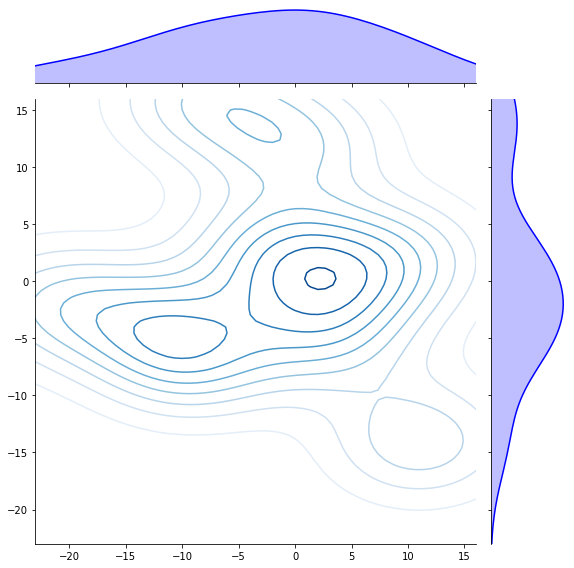